# Graph Neural Networks (GNNs)
## Part II: Transformer
We are going to play with attention in the context for molecular property prediciton. It's recommended that you're familiar with the recent lectures on GNNs and with the previous lab on MPNN in molecular property prediction.

# Setup
We are going to use the same dataset and most of the codebase as in the previous lab.

In [4]:
!pip install dgllife
!pip install dgl
!pip install rdkit

In [5]:
!pip install torchmetrics
!pip install torch_geometric

In [6]:
!pip install wandb

In [8]:
from google.colab import files
uploaded = files.upload()


Saving checker.py to checker.py


## Copied code
I'm going to copy most of the code for convenience.

In [9]:
import copy
from abc import ABC, abstractmethod
from pathlib import Path
from typing import Dict, Any, Tuple
from typing import Type

import dgl
import numpy as np
import torch
from dgl.data import Subset
from dgl.dataloading import GraphDataLoader
from dgllife.data import FreeSolv
from dgllife.utils import CanonicalAtomFeaturizer, SMILESToBigraph
from dgllife.utils import ScaffoldSplitter
from torch import nn
from torch_geometric.utils import to_dense_batch
from torchmetrics import Metric
from tqdm.autonotebook import tqdm

from checker import expected_gat_output, expected_dot_attention_output, sub_optimal_multihead_attention_output, \
    expected_multihead_attention_output

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [10]:
class LoggerBase(ABC):
    def __init__(self, logdir: str | Path):
        self.logdir = Path(logdir)
        self.logdir.mkdir(parents=True, exist_ok=True)

    @abstractmethod
    def log_metrics(self, metrics: Dict[str, Any], prefix: str):
        ...

    @abstractmethod
    def close(self):
        ...


class WandbLogger(LoggerBase):
    def __init__(
            self, logdir: str | Path, project_name: str, experiment_name: str, **kwargs: Dict[str, Any]
    ):
        super().__init__(logdir)
        import wandb
        self.project_name = project_name
        self.experiment_name = experiment_name
        self.kwargs = kwargs
        self.run = wandb.init(
            dir=self.logdir,
            project=self.project_name,
            name=self.experiment_name,
            **self.kwargs,
        )

    def log_metrics(self, metrics: Dict[str, Any], prefix: str):
        metrics = {f"{prefix}/{k}": v for k, v in metrics.items()}
        self.run.log(metrics)

    def close(self):
        self.run.finish()


class DummyLogger(LoggerBase):  # If you don't want to use any logger, you can use this one
    def log_metrics(self, metrics: Dict[str, Any], prefix: str):
        pass

    def close(self):
        pass

    def restart(self):
        pass


class MetricList:
    def __init__(self, metrics: Dict[str, Metric]):
        self.metrics = copy.deepcopy(metrics)

    def update(self, preds: torch.Tensor, targets: torch.Tensor) -> None:
        for name, metric in self.metrics.items():
            metric.update(preds.detach().cpu(), targets.cpu())

    def compute(self) -> Dict[str, float]:
        metrics = {}
        for name, metric_fn in self.metrics.items():
            metrics[name] = metric_fn.compute().item()
            metric_fn.reset()
        return metrics


class Trainer:
    def __init__(
            self,
            *,
            run_dir: str | Path,
            train_dataset: Subset,
            valid_dataset: Subset,
            train_metrics: Dict[str, Metric],
            valid_metrics: Dict[str, Metric],
            model: nn.Module,
            logger: LoggerBase,
            optimizer_kwargs: Dict[str, Any],
            optimizer_cls: Type[torch.optim.Optimizer] = torch.optim.Adam,
            n_epochs: int,
            train_batch_size: int = 32,
            valid_batch_size: int = 16,
            device: str = "cuda",
            valid_every_n_epochs: int = 1,
            loss_fn=nn.MSELoss()
    ):
        self.run_dir = Path(run_dir)
        self.train_loader = GraphDataLoader(
            dataset=train_dataset,
            batch_size=train_batch_size,
            shuffle=True,
        )
        self.valid_loader = GraphDataLoader(
            dataset=valid_dataset,
            batch_size=valid_batch_size,
            shuffle=True,
        )
        self.train_metrics = MetricList(train_metrics)
        self.valid_metrics = MetricList(valid_metrics)
        self.logger = logger
        self.model = model
        self.optimizer = optimizer_cls(model.parameters(), **optimizer_kwargs)
        self.n_epochs = n_epochs
        self.device = device
        self.valid_every_n_epochs = valid_every_n_epochs
        self.loss_fn = loss_fn
        self.model.to(device)

    @torch.no_grad()
    def validate(self, dataloader: GraphDataLoader, prefix: str) -> Dict[str, float]:
        previous_mode = self.model.training
        self.model.eval()
        losses = []
        for _, graphs, labels in dataloader:
            graphs = graphs.to(self.device)
            labels = labels.to(self.device)
            preds = self.model(graphs)
            loss = self.loss_fn(preds, labels)
            losses.append(loss.item())
            self.valid_metrics.update(preds, labels)
        self.model.train(mode=previous_mode)
        metrics = {"loss": np.mean(losses)} | self.valid_metrics.compute()
        self.logger.log_metrics(metrics=metrics, prefix=prefix)
        return metrics

    def train(self) -> Dict[str, float]:
        self.model.train()
        valid_metrics = {}
        for epoch in tqdm(range(self.n_epochs), total=self.n_epochs):
            for _, graphs, labels in self.train_loader:
                self.optimizer.zero_grad()
                graphs = graphs.to(self.device)
                labels = labels.to(self.device)
                preds = self.model(graphs)
                loss = self.loss_fn(preds, labels)
                loss.backward()
                self.optimizer.step()

                self.train_metrics.update(preds, labels)
                train_metrics = {"loss": loss.item()} | self.train_metrics.compute()
                self.logger.log_metrics(metrics=train_metrics, prefix="train")

                if epoch % self.valid_every_n_epochs == 0 or epoch == self.n_epochs - 1:
                    valid_metrics = self.validate(self.valid_loader, prefix="valid")

        return valid_metrics

    def test(self, dataset: Subset) -> Dict[str, float]:
        dataloader = GraphDataLoader(
            dataset=dataset,
            batch_size=16,
            shuffle=False,
        )
        return self.validate(dataloader, prefix="test")

    def close(self):  # close the logger, not really required for wandb
        self.logger.close()

In [11]:
def to_dense_embeddings(node_embeddings: torch.Tensor, graph: dgl.DGLGraph, fill_value: float = 0.0) -> Tuple[
    torch.Tensor, torch.Tensor]:
    """
    Converts sparse node embeddings to dense node embeddings with padding.
    Arguments:
        node_embeddings: node embeddings in a sparse format, i.e. [total_num_nodes, hidden_size]
        graph: a batch of graphs
        fill_value: a value to fill the padding with
    Returns:
        node_embeddings: node embeddings in a dense format, i.e. [batch_size, max_num_nodes, hidden_size]
        mask: a mask indicating which nodes are real and which are padding, i.e. [batch_size, max_num_nodes]
    """
    num_nodes = graph.batch_num_nodes()  # e.g. [2, 3, 3]
    indices = torch.arange(len(num_nodes), device=num_nodes.device)
    batch = torch.repeat_interleave(indices, num_nodes).long()  # e.g. [0, 0, 1, 1, 1, 2, 2, 2]
    return to_dense_batch(node_embeddings, batch,
                          fill_value=fill_value)  # that's the only reason we have torch_geometric in the requirements


def to_sparse_embeddings(node_embeddings: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """
    Converts dense node embeddings to sparse node embeddings.
    Arguments:
        node_embeddings: node embeddings in a dense format, i.e. [batch_size, max_num_nodes, hidden_size]
        mask: a mask indicating which nodes are real and which are padding, i.e. [batch_size, max_num_nodes]
    Returns:
        node_embeddings: node embeddings in a sparse format, i.e. [total_num_nodes, hidden_size]
    """
    return node_embeddings[mask]

In [12]:
class ReadoutBase(nn.Module, ABC):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size

    @abstractmethod
    def forward(self, node_embeddings: torch.Tensor, graph: dgl.DGLGraph) -> torch.Tensor:
        ...


class SumReadout(ReadoutBase):
    def forward(self,
                node_embeddings: torch.Tensor,
                graph: dgl.DGLGraph) -> torch.Tensor:
        """
        Attributes:
            node_embeddings: node embeddings in a sparse format, i.e. [total_num_nodes, hidden_size]
            graph: a DGLGraph that contains the graph structure
        Returns:
            graph_embeddings: graph embeddings of shape.[batch_size, hidden_size]
        """
        # We can also use dgl.sum_nodes function, but let assume it's forbidden in that notebook ;)
        node_embeddings, _ = to_dense_embeddings(node_embeddings, graph)
        return node_embeddings.sum(dim=1)

## Updated code
Some of the previous code is slightly updated.

In [13]:
class GNNLayerBase(ABC, nn.Module):
    def _init(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size

    @abstractmethod
    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor | None,
                graph: dgl.DGLGraph) -> torch.Tensor:
        ...


class GNN(nn.Module):
    def __init__(self,
                 node_features_size: int,
                 hidden_size: int,
                 output_size: int,
                 gnn_layer_cls: Type[GNNLayerBase],
                 gnn_layer_kwargs: Dict[str, Any],
                 gnn_n_layers: int,
                 gnn_layer_requires_dense: bool,
                 readout_cls: Type[ReadoutBase]):
        super().__init__()
        self.linear_node = nn.Linear(node_features_size, hidden_size)
        self.gnn_layers = nn.ModuleList([
            gnn_layer_cls(hidden_size=hidden_size, **gnn_layer_kwargs)
            for _ in range(gnn_n_layers)
        ])
        self.readout = readout_cls(hidden_size=hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )
        self.gnn_layer_requires_dense = gnn_layer_requires_dense

    def forward(self, graph: dgl.DGLGraph) -> torch.Tensor:
        node_embeddings = graph.ndata['h']
        node_embeddings = self.linear_node(node_embeddings)
        if self.gnn_layer_requires_dense:
            node_embeddings, mask = to_dense_embeddings(node_embeddings, graph)
        else:
            mask = None
        for layer in self.gnn_layers:
            node_embeddings = layer(node_embeddings=node_embeddings, mask=mask, graph=graph)
        if self.gnn_layer_requires_dense:
            node_embeddings = to_sparse_embeddings(node_embeddings, mask)
        graph_embedding = self.readout(node_embeddings, graph)
        predictions = self.mlp(graph_embedding)
        return predictions

In [14]:
def test_gnn_layer(mpnn_layer_cls: Type[GNNLayerBase], expected_output: torch.Tensor, requires_dense: bool = False):
    node_featurizer = CanonicalAtomFeaturizer()
    graph_a = SMILESToBigraph(node_featurizer=node_featurizer, add_self_loop=True)("CN(C)C(=O)c1ccc(cc1)OC")
    graph_b = SMILESToBigraph(node_featurizer=node_featurizer, add_self_loop=True)("CS(=O)(=O)Cl")
    torch.manual_seed(0)
    graph = dgl.batch([graph_a, graph_b])
    linear_nodes = nn.Linear(node_featurizer.feat_size(), 12)
    node_embeddings = linear_nodes(graph.ndata['h'])
    layer = mpnn_layer_cls(hidden_size=12)
    if requires_dense:
        node_embeddings, mask = to_dense_embeddings(node_embeddings, graph)
    else:
        mask = None
    result = layer(node_embeddings=node_embeddings, mask=mask, graph=graph)
    assert torch.allclose(result, expected_output, atol=1e-4)

# Attention
As you know from the lectures, the Transformer architecture is based on the attention mechanism. However, it's worth noting that attention is not a mechanism from the Transformer architecture, but rather a general concept used many times before. We've actually used some form of attention in the previous lab in `AttentionReadout` class. It was aggregating the information from graph nodes by computing a weighted average of the nodes embeddings using dynamically computed weights. The attention in the Transformer architecture is very similar - the main difference is that attention in Transformer is computed for every token (node) and is used to update the token/node embedding. In the context of graphs, we have a second well-known attention-based architecture called [Graph Attention Network (GAT)](https://arxiv.org/abs/1710.10903). The attention in GAT differs from attention in Transformer in two ways:
1. In GAT, the attention for a given node is computed using the node's neighbors while in Transformer it's computed using all other nodes.
2. GAT uses additive attention, while Transformer uses (multiheaded) dot-product one.

Let's start with implementation of GAT layer.

## Additive attention (GAT)
### Task 1. GATLayer (2 points).
Your task is to:
1\) implement a GAT layer which is MPNN that uses attention mechanism for neighbor aggregation. The formula for the update is the following:
$$
m_i = W_1 x_i
$$
$$
score_{ij} = LeakyReLU(W_2(m_i | m_j)),
$$
$$
\alpha_{ij} = \frac{exp(score_{ij})}{\sum_{k \in \mathcal{N}(i) \cup \{i\}} exp(score_{ik})}
$$
$$
x'_i = \sum_{j \in \mathcal{N}(i) \cup \{i\}} \alpha_{ij} m_j
$$
where | stands for concatenation. Note that in our code, we added self-loops to the graph, so $\mathcal{N}(i) \cup \{i\} = \mathcal{N}(i)$.

2\) Briefly explain why the attention in GAT is called additive:

Your explanation: The attention mechanism in Graph Attention Networks (GAT) is called "additive" because it utilizes a weighted sum of neighbour node features multiplied by learned attention coefficients.

In [15]:
class GATLayer(GNNLayerBase):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(2 * hidden_size, hidden_size)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor | None,
                graph: dgl.DGLGraph) -> torch.Tensor:
        start_nodes, end_nodes = graph.edges(
            order='srcdst')  # note that our graph is bi-directed and contains self-loops

        messages = self.linear_1(node_embeddings)
        messages_i = messages[start_nodes]
        messages_j = messages[end_nodes]

        concat_messages = torch.cat([messages_i, messages_j], dim=-1)
        scores = self.leaky_relu(self.linear_2(concat_messages))

        exp_scores = torch.exp(scores)
        scores_dense, mask = to_dense_batch(exp_scores, start_nodes.long(), fill_value=0.0)
        alphas = scores_dense/scores_dense.sum(dim=1, keepdim=True)

        message_j_dense, _ = to_dense_batch(messages_j, start_nodes.long(), fill_value=0.0)
        output = (alphas * message_j_dense).sum(dim=1)

        return output


test_gnn_layer(GATLayer, expected_gat_output)

## Dot-product attention
Having the GAT implemented, we can move to the attention used in the Transformer model. It's called "multi-head dot-product attention", but for the moment let's focus on the "dot-product" part of the name.

### Task 2. Dot-product attention (2 points).
Your task is to:
1\) implement the dot-product attention given by the following formula:
$$
v_i = W_v x_i, \quad k_i = W_k x_i, \quad q_i = W_q x_i, \quad W_v, W_k, W_q \in \mathbb{R}^{D \times D}, \quad x_i \in \mathbb{R}^{D}
$$
$$
score_{ij} = \frac{q_i^T k_j}{\sqrt{D}}
$$
$$
a_{ij} = \frac{exp(score_{ij})}{\sum_{k=1}^n exp(score_{ik})}
$$
$$
x'_i = \sum_{j=1}^n a_{ij} v_j
$$
2\) Briefly explain what's the advantage of dot-product attention over the additive one.
Your explanation: The main reason is that dot-product attention is more computationally efficient than additive attention. The reason is that the dot product is a simpler operation for the computer comparing to additive attention weighted sum. The dot-product is also higly parallelizable which helps with parallel processing using GPU's.

In [16]:
import torch.nn.functional as F

class DotProductAttention(GNNLayerBase):
    def __init__(self, hidden_size: int, output_size: int | None = None):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size or hidden_size
        self.linear_v = nn.Linear(hidden_size, self.output_size)
        self.linear_k = nn.Linear(hidden_size, self.output_size)
        self.linear_q = nn.Linear(hidden_size, self.output_size)
        self.sqrt_d = np.sqrt(self.output_size)

    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor,
                graph: dgl.DGLGraph) -> torch.Tensor:
        """
        Arguments:
            node_embeddings: node embeddings in a dense format, i.e. [batch_size, max_num_nodes, hidden_size]
            mask: a mask indicating which nodes are real, i.e. [batch_size, max_num_nodes]
        Returns:
            node_embeddings: node embeddings in a dense format, i.e. [batch_size, max_num_nodes, hidden_size]
        """
        values = self.linear_v(node_embeddings)
        keys = self.linear_k(node_embeddings)
        queries = self.linear_q(node_embeddings)

        scores = torch.matmul(queries, keys.transpose(1, 2)) / self.sqrt_d
        scores = scores.masked_fill(mask.unsqueeze(-1) == 0, float('-inf'))
        scores = scores.masked_fill(mask.unsqueeze(-1).transpose(1,2) == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = torch.nan_to_num(attention_weights)

        attention_values = torch.matmul(attention_weights, values)

        return attention_values

torch.set_printoptions(precision=6)
test_gnn_layer(DotProductAttention, expected_dot_attention_output, requires_dense=True)

## Multi-head dot-product attention
Great! We can now implement the actual attention used in the Transformer!
### Task 3. Multi-head dot-product attention (2 points).
Your task is to:
1\) Implement multi-head dot-product attention (in a naive form). Let's parametrize the attention from the previous task with $W_v, W_k, W_q$ matrices so that we can rewrite it:
$$
x'_i = attention(W_v, W_k, W_q)
$$
The multi-head attention is a simple concatenation of the outputs of different attentions and is give by the following formula:
$$
x'_i = concat(attention_1(W_v^{(1)}, W_k^{(1)}, W_q^{(1)}), \dots, attention_H(W_v^{(H)}, W_k^{(H)}, W_q^{(H)}))W
$$
where matrices $W_v^{(h)}, W_k^{(h)}, W_q^{(h)} \in \mathbb{R}^{(D / H) \times D}$ are distinct for each head $h \in \{1, \dots, H\}$ and have reduced output sizes. The matrix $W \in \mathbb{R}^{D \times D}$.
2\) Briefly explain what is the advantage of the multi-head dot-product attention over the (single-head) dot-product one.
Your explanation: The main reason is that multi-head attention allows the model to attend to different parts of the input sequence in parallel, while using different learned projection weights, the model gains expressivity and is able to learn more complex representations.


In [18]:
class SuboptimalMultiHeadAttention(GNNLayerBase):
    def __init__(self, hidden_size: int, n_heads: int = 3):
        super().__init__()
        assert hidden_size % n_heads == 0
        self.output_linear = nn.Linear(hidden_size, hidden_size)  # the last linear layer (W)
        self.attentions = nn.ModuleList()
        for _ in range(n_heads):
            attention = DotProductAttention(hidden_size, output_size=int(hidden_size/n_heads))
            self.attentions.append(attention)

    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor,
                graph: dgl.DGLGraph) -> torch.Tensor:
        outputs = []

        for attention_head in self.attentions:
            head_output = attention_head(node_embeddings, mask, graph)
            outputs.append(head_output)

        multi_head_output = torch.cat(outputs, dim=-1)
        output = self.output_linear(multi_head_output)
        output = output.masked_fill(mask.unsqueeze(-1) == 0, 0)

        return output

test_gnn_layer(SuboptimalMultiHeadAttention, sub_optimal_multihead_attention_output, requires_dense=True)

### Task 4. Multi-head dot-product attention (2 points).
The attention from the previous task works, but requires to loop over `n_attention` heads. We can avoid that! Your task is to implement multi-head dot-product attention defined in the previous task in a batch-manner (without using loops).

In [19]:
class MultiHeadAttention(GNNLayerBase):
    def __init__(self, hidden_size: int, n_heads: int = 3):
        super().__init__()
        assert hidden_size % n_heads == 0
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.linear_v = nn.Linear(hidden_size, hidden_size)
        self.linear_k = nn.Linear(hidden_size, hidden_size)
        self.linear_q = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, hidden_size)
        self.sqrt_d = np.sqrt(hidden_size // n_heads)

    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor,
                graph: dgl.DGLGraph) -> torch.Tensor:
        """
        Arguments:
            node_embeddings: node embeddings in a dense format, i.e. [batch_size, max_num_nodes, hidden_size]
            mask: a mask indicating which nodes are real, i.e. [batch_size, max_num_nodes]
        Returns:
            node_embeddings: node embeddings in a dense format, i.e. [batch_size, max_num_nodes, hidden_size]
        """
        values = self.linear_v(node_embeddings)
        keys = self.linear_k(node_embeddings)
        queries = self.linear_q(node_embeddings)

        values = values.reshape(values.shape[0], values.shape[1], self.n_heads,
                                -1)  # [batch_size, max_num_nodes, n_heads, hidden_size // n_heads]
        keys = keys.reshape(keys.shape[0], keys.shape[1], self.n_heads,
                            -1)  # [batch_size, max_num_nodes, n_heads, hidden_size // n_heads]
        queries = queries.reshape(queries.shape[0], queries.shape[1], self.n_heads,
                                  -1)  # [batch_size, max_num_nodes, n_heads, hidden_size // n_heads]
        values = values.transpose(-2, -3)  # [batch_size, n_heads, max_num_nodes, hidden_size // n_heads]
        keys = keys.transpose(-2, -3)  # [batch_size, n_heads, max_num_nodes, hidden_size // n_heads]
        queries = queries.transpose(-2, -3)  # [batch_size, n_heads, max_num_nodes, hidden_size // n_heads]

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.sqrt_d
        scores = scores.masked_fill(mask.unsqueeze(1).unsqueeze(-1) == 0, float('-inf'))
        scores = scores.masked_fill(mask.unsqueeze(1).unsqueeze(-1).transpose(2,3) == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)
        attention_values = torch.matmul(attention_weights, values)
        attention_values = attention_values.transpose(-2, -3).reshape(node_embeddings.shape)
        output = self.linear_out(attention_values)
        output = output.masked_fill(mask.unsqueeze(-1) == 0, 0)

        return output

test_gnn_layer(MultiHeadAttention, expected_multihead_attention_output, requires_dense=True)

# Transformer
We have implemented the attention mechanism. Transformer also consist of other parts but they're rather boring and here's the implementation:


In [20]:
class TransformerLayer(GNNLayerBase):
    def __init__(self, hidden_size: int, n_heads: int = 4):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention = MultiHeadAttention(hidden_size=hidden_size, n_heads=n_heads)
        self.norm_1 = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.norm_2 = nn.LayerNorm(hidden_size)

    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor,
                graph: dgl.DGLGraph) -> torch.Tensor:
        node_embeddings = self.attention(node_embeddings, mask, graph) + node_embeddings
        node_embeddings = self.norm_1(node_embeddings)
        node_embeddings = self.feed_forward(node_embeddings) + node_embeddings
        node_embeddings = self.norm_2(node_embeddings)
        node_embeddings = torch.masked_fill(node_embeddings, ~mask.unsqueeze(-1), 0.0)
        return node_embeddings

## Expressiveness of a Transformer as GNN
Let's play for a while with the expressiveness of a TransformerLayer in a GNN. For that purpose, let us simplify the graph featurizer used to transform a SMILES to a graph as much as possible, so that the featurized graph contains only the information about the atom tyoe.

In [21]:
from dgllife.utils import BaseAtomFeaturizer, ConcatFeaturizer, atom_type_one_hot

atom_type_featurizer = BaseAtomFeaturizer(
    featurizer_funcs={
        "h": ConcatFeaturizer([atom_type_one_hot]),
    }
)
smiles_to_graph_simple = SMILESToBigraph(
    node_featurizer=atom_type_featurizer,
    add_self_loop=True,
)

Let us also define some GNN constructor wrappers for convenience:

In [22]:
def transformer_gnn(node_features_size: int, n_layers: int) -> GNN:
    return GNN(
        node_features_size=node_features_size,
        hidden_size=64,
        output_size=1,
        gnn_layer_cls=TransformerLayer,
        gnn_layer_kwargs={},
        gnn_n_layers=n_layers,
        gnn_layer_requires_dense=True,
        readout_cls=SumReadout,
    )


def gat_gnn(node_features_size: int, n_layers: int) -> GNN:
    return GNN(
        node_features_size=node_features_size,
        hidden_size=64,
        output_size=1,
        gnn_layer_cls=GATLayer,
        gnn_layer_kwargs={},
        gnn_n_layers=n_layers,
        gnn_layer_requires_dense=False,
        readout_cls=SumReadout,
    )


And define two molecules that are pretty dissimilar:

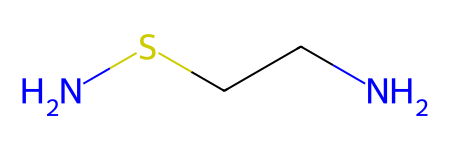

In [23]:
from rdkit.Chem import MolFromSmiles

smiles_a = "NSCCN"
MolFromSmiles(smiles_a)

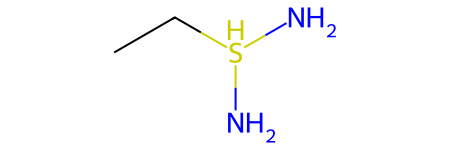

In [24]:
smiles_b = "NS(CC)N"
MolFromSmiles(smiles_b)

In [25]:
graph_a = smiles_to_graph_simple(smiles_a)
graph_b = smiles_to_graph_simple(smiles_b)
batch = dgl.batch([graph_a, graph_b])

### Task 5. Expressiveness of a Transformer as a GNN (2 points).
Using the code provided below, run few experiments and answer the following questions:
1. Explain why the Transformer-based GNN can (or cannot) distinguish between the two molecules.
2. Why can (or cannot) we make the Transformer-based GNN to distinguish between the molecules by manipulating the number of layers?
3. Explain why the GAT-based GNN can (or cannot) distinguish between the two molecules.
4. Why can (or cannot) we make the GAT-based GNN to distinguish between the molecules by manipulating the number of layers?




1.   The Transformer-based Graph Neural Network (GNN) may have problems to distinguish between two molecules. The reason is that it doesn't have information about the positions of nodes within the graph and it's structural relationships. Transformers without some sort of positional encodings treat all input positions equally, which results in lack of spatial information needed to distinguish between molecules.
2.   Increasing the number of layers in a Transformer-based GNN without some sort of structural encodings doesn't help with the issue of distinguishing between molecules. The problem is in the architecture of the Transformer as mentioned in the previous answear.
3.   The Graph Attention Network-based GNN without structural encodings is still able to distinguish between molecules. GAT's attention mechanism is able to focus on different neighbors and can capture local graph structures. However it is not as effective as it might be when we add structural encodings.
4.   As it turns out more layers doesn't improve the ability to distinguish different molecules in this example. With an increased number of layers, the GAT-based GNN may start to prioritize global information over local information, the other reason coulb be that more complex models can have problems to generalize, which can lead to overfitting.





In [26]:
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=2)
print(transformer(batch))
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=10)
print(transformer(batch))
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=3)
print(transformer(batch))
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=5)
print(transformer(batch))
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=200)
print(transformer(batch))
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=70)
print(transformer(batch))
transformer = transformer_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=80)
print(transformer(batch))


tensor([[-0.789444],
        [-0.789444]], grad_fn=<AddmmBackward0>)
tensor([[1.804276],
        [1.804276]], grad_fn=<AddmmBackward0>)
tensor([[0.392649],
        [0.392649]], grad_fn=<AddmmBackward0>)
tensor([[-1.619401],
        [-1.619401]], grad_fn=<AddmmBackward0>)
tensor([[0.791126],
        [0.791126]], grad_fn=<AddmmBackward0>)
tensor([[-0.120115],
        [-0.120114]], grad_fn=<AddmmBackward0>)
tensor([[-0.832805],
        [-0.832804]], grad_fn=<AddmmBackward0>)


In [28]:
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=3)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=2)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=4)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=40)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=60)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=80)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=200)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=140)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=20)
print(gat(batch))
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=20)
print(gat(batch))

tensor([[0.365955],
        [0.366614]], grad_fn=<AddmmBackward0>)
tensor([[0.112383],
        [0.113800]], grad_fn=<AddmmBackward0>)
tensor([[-0.088350],
        [-0.088703]], grad_fn=<AddmmBackward0>)
tensor([[-0.198945],
        [-0.198945]], grad_fn=<AddmmBackward0>)
tensor([[-0.076528],
        [-0.076528]], grad_fn=<AddmmBackward0>)
tensor([[0.167808],
        [0.167808]], grad_fn=<AddmmBackward0>)
tensor([[-0.152705],
        [-0.152705]], grad_fn=<AddmmBackward0>)
tensor([[-0.196797],
        [-0.196797]], grad_fn=<AddmmBackward0>)
tensor([[0.040956],
        [0.040956]], grad_fn=<AddmmBackward0>)
tensor([[0.137768],
        [0.137768]], grad_fn=<AddmmBackward0>)


# Positional Encodings
As you finished the previous task, you know that our Transformer-based GNN cannot distinguish between the two molecules, and you know the exact reason. To overcome that reason, we can use structural encodings which are the analog of positional encodings used in the original textual Transformer. The purpose of the structural encoding is to encode the structure of a graph into the initial node features. For example, we can use the random walk positional encoding from dgllife package: [RandomWalkPE](https://docs.dgl.ai/en/1.1.x/generated/dgl.transforms.RandomWalkPE.html):


In [29]:
from dgllife.utils.mol_to_graph import construct_bigraph_from_mol
from dgl import random_walk_pe
from rdkit import Chem


class PositionalEncodingFeaturizerBase:
    @abstractmethod
    def feat_size(self) -> int:
        pass


class JointFeaturizer:
    def __init__(self, atom_featurizer: BaseAtomFeaturizer, pe_featurizer: PositionalEncodingFeaturizerBase):
        self.atom_featurizer = atom_featurizer
        self.pe_featurizer = pe_featurizer

    def feat_size(self) -> int:
        return self.atom_featurizer.feat_size() + self.pe_featurizer.feat_size()

    def __call__(self, mol: Chem.Mol):
        atom_features = self.atom_featurizer(mol)['h']
        pe_features = self.pe_featurizer(mol)
        return {'h': torch.cat([atom_features, pe_features], dim=-1)}


class RandomWalkPEFeaturizer(PositionalEncodingFeaturizerBase):
    def __init__(self, n_steps: int = 16):
        self.n_steps = n_steps

    def feat_size(self) -> int:
        return self.n_steps

    def __call__(self, mol: Chem.Mol):
        graph = construct_bigraph_from_mol(mol)
        return random_walk_pe(
            graph, k=self.n_steps
        )


## Task 6. Random walk. (1 points).
Given the following code:
```
smiles = 'C1CCC2CCCCC2C1'
mol = MolFromSmiles(smiles)
output = RandomWalkPEFeaturizer(n_steps=16)(mol)
```
Briefly explain the meaning of the `output[i, k]` value. Is it a probability of some event? What is the event?

From how i understand it, the output[i, k] is the probability of the event that the random walk is in the certain atom after k steps when starting from i'th atom.


In [30]:
node_pe_featurizer = JointFeaturizer(
    atom_featurizer=atom_type_featurizer,
    pe_featurizer=RandomWalkPEFeaturizer(n_steps=16),
)
smiles_to_graph_pe = SMILESToBigraph(
    node_featurizer=node_pe_featurizer,
    add_self_loop=True,
)

We can now observe the effect of the positional encodings on the Transformer-based GNN:

In [31]:
graph_a = smiles_to_graph_pe(smiles_a)
graph_b = smiles_to_graph_pe(smiles_b)
batch = dgl.batch([graph_a, graph_b])
transformer = transformer_gnn(node_features_size=node_pe_featurizer.feat_size(), n_layers=3)
transformer(batch)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:53: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return th.as_tensor(data, dtype=dtype)


tensor([[-0.070284],
        [-0.067226]], grad_fn=<AddmmBackward0>)

## Random Walk and expressiveness of MPNNs
Using random walk as a positional encoding can also help MPNN to be more expressive (distinguish more non-isomorphic graphs).

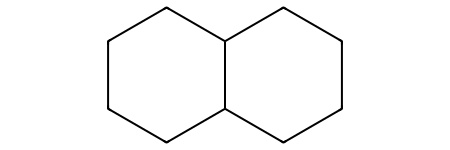

In [34]:
smiles_a = 'C1CCC2CCCCC2C1'
MolFromSmiles(smiles_a)

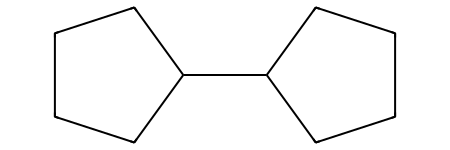

In [35]:
smiles_b = 'C1CCC(C1)C2CCCC2'
MolFromSmiles(smiles_b)

### Task 7. Expressiveness of a MPNN (2 points).
Using the code provided below, run few experiments and answer the following questions:
1. Explain why the GAT-based GNN can (or cannot) distinguish between the two molecules.
2. Explain why the Transformer-based GNN with random walk positional encodings can (or cannot) distinguish between the two molecules.
3. Explain why the GAT-based GNN with random walk positional encodings can (or cannot) distinguish between the two molecules.

1.   Here we can see that the GAT-based GNN by itself doesn't have enough powet to distinguish between two different molecules. As mentioned in question 5, some sort of structural encoding could help with that.
2.   Adding random walk positional encodings to a Transformer-based GNN can improve its ability to distinguish between molecules. Positional encodings takes in to account the structural information considering the local graph context, which helps to learn spatial relationships between nodes. Random walk positional encodings can provide the model with a sense of the order in which nodes are visited during random walks. This information can improve the model's ability to distinguish different molecules.
3.   Adding random walk positional encodings into a GAT-based GNN can further improve its ability to distinguish between molecules. Adding structural encodings to attention mechanism in GAT allows to find important local structures in graph and improves its discriminative abilities. Random walk positional encodings can provide the model with a sense of the order in which nodes are visited during random walks.


In [44]:
graph_a = smiles_to_graph_simple(smiles_a)
graph_b = smiles_to_graph_simple(smiles_b)
batch = dgl.batch([graph_a, graph_b])
gat = gat_gnn(node_features_size=atom_type_featurizer.feat_size(), n_layers=5)
gat(batch)

tensor([[-0.141115],
        [-0.141115]], grad_fn=<AddmmBackward0>)

In [37]:
graph_a = smiles_to_graph_pe(smiles_a)
graph_b = smiles_to_graph_pe(smiles_b)
batch = dgl.batch([graph_a, graph_b])
transformer = transformer_gnn(node_features_size=node_pe_featurizer.feat_size(), n_layers=3)
transformer(batch)

tensor([[3.450411],
        [3.743921]], grad_fn=<AddmmBackward0>)

In [38]:
graph_a = smiles_to_graph_pe(smiles_a)
graph_b = smiles_to_graph_pe(smiles_b)
batch = dgl.batch([graph_a, graph_b])
gat = gat_gnn(node_features_size=node_pe_featurizer.feat_size(), n_layers=3)
gat(batch)

tensor([[0.184316],
        [0.186424]], grad_fn=<AddmmBackward0>)

# Experiments
Ok, now we can quickly play with the Transformer-based and GAT-based GNNs and see how it performs on the molecular property prediction task.

In [39]:
from datetime import datetime
from torchmetrics import MeanAbsoluteError as MAE
from torchmetrics import MeanSquaredError as MSE
from torchmetrics import PearsonCorrCoef as PCC

metrics = {
    "mae": MAE(),
    "mse": MSE(),
    "pcc": PCC(),
}


def get_time_stamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

## Task 8. Train GAT (2 points).
1. Tune hyperparameters of a GNN with `GAT` as a layer to obtain at most 2.0 MAE on the validation set. You can modify the GNN/MPNN architecture so it uses regularization tricks. You can also change the featurization functions. Don't change the validation batch size. If your validation MAE is in (2.0, 2.5], you can obtain 1 point.
2. Report the obtained MAE on the validation and test set (only the former need to be lower than 2.0 MAE).
3. Provide the link to the final run: [https://wandb.ai/teddy8/mldd23/runs/wa2xu8fc]

In [46]:
node_featurizer = CanonicalAtomFeaturizer()
dataset = FreeSolv(
    smiles_to_graph=SMILESToBigraph(
        node_featurizer=node_featurizer,
        add_self_loop=True,
    )
)
splitter = ScaffoldSplitter()
train, valid, test = splitter.train_val_test_split(dataset)  # it's deterministic

model = GNN(
    node_features_size=node_featurizer.feat_size(),
    hidden_size=64,
    output_size=1,
    gnn_layer_cls=GATLayer,
    gnn_layer_kwargs={},
    gnn_n_layers=4,
    gnn_layer_requires_dense=False,
    readout_cls=SumReadout,
)

trainer = Trainer(
    run_dir="experiments",
    train_dataset=train,
    valid_dataset=valid,
    train_metrics=metrics,
    valid_metrics=metrics,
    train_batch_size=32,
    model=model,
    logger=WandbLogger(
        logdir="runs/mpnn",
        project_name="mldd23",
        experiment_name=f"gat_{get_time_stamp()}",
    ),
    optimizer_kwargs={"lr": 1e-4},
    n_epochs=100,
    device="cpu",
    valid_every_n_epochs=1,
)

valid_metrics = trainer.train()
test_metrics = trainer.test(test)
trainer.close()
print(f"Validation metrics: {valid_metrics}")
print(f"Test metrics: {test_metrics}")

Processing dgl graphs from scratch...
Start initializing RDKit molecule instances...
Start computing Bemis-Murcko scaffolds.


  0%|          | 0/100 [00:00<?, ?it/s]

test/loss,▁
test/mae,▁
test/mse,▁
test/pcc,▁
train/loss,▇▄▅▃▄▄█▃▄▃▇▄▄▆▄▃▅▂▂▂▂▂▃▂▂▁▂▂▂▂▂▂▂▂▂▁▂▂▁▂
train/mae,▆▄▅▄▅▄█▄▄▄▅▄▄▅▄▄▄▃▃▃▃▃▃▃▂▁▃▂▃▃▃▂▂▃▃▂▂▂▂▃
train/mse,▇▄▅▃▄▄█▃▄▃▇▄▄▆▄▃▅▂▂▂▂▂▃▂▂▁▂▂▂▂▂▂▂▂▂▁▂▂▁▂
train/pcc,▃▅▁▄▄▂ ▅▃▄▄▄▆▅▄▆▆▆▇▇▇▇▆▇▇ ██▆▇█▇▇▇▇█████
valid/loss,█▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/mae,█▆▅▅▅▅▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁
valid/mse,█▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Validation metrics: {'loss': 9.285930514335632, 'mae': 1.9023702144622803, 'mse': 9.285930633544922, 'pcc': 0.9110189080238342}
Test metrics: {'loss': 6.550235378742218, 'mae': 2.1944973468780518, 'mse': 7.851574420928955, 'pcc': 0.7606539130210876}


In [47]:
class TransformerLayer(GNNLayerBase):
    def __init__(self, hidden_size: int, n_heads: int = 4):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention = SuboptimalMultiHeadAttention(hidden_size=hidden_size, n_heads=n_heads)
        self.norm_1 = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.norm_2 = nn.LayerNorm(hidden_size)

    def forward(self,
                node_embeddings: torch.Tensor,
                mask: torch.Tensor,
                graph: dgl.DGLGraph) -> torch.Tensor:
        node_embeddings = self.attention(node_embeddings, mask, graph) + node_embeddings
        node_embeddings = self.norm_1(node_embeddings)
        node_embeddings = self.feed_forward(node_embeddings) + node_embeddings
        node_embeddings = self.norm_2(node_embeddings)
        node_embeddings = torch.masked_fill(node_embeddings, ~mask.unsqueeze(-1), 0.0)
        return node_embeddings

## Task 9. Train Transformer (2 points).
1. Tune hyperparameters of a GNN with `Transformer` as a layer to obtain at most 2.0 MAE on the validation set. You can modify the GNN/MPNN architecture so it uses regularization tricks. You can also change the featurization functions. Don't change the validation batch size. If your validation MAE is in (2.0, 2.5], you can obtain 1 point.
2. Report the obtained MAE on the validation and test set (only the former need to be lower than 2.0 MAE).
3. Provide the link to the final run: [https://wandb.ai/teddy8/mldd23/runs/o8g9b7sn]

In [52]:
node_featurizer = CanonicalAtomFeaturizer()
dataset = FreeSolv(
    smiles_to_graph=SMILESToBigraph(
        node_featurizer=node_featurizer,
        add_self_loop=True,
    )
)
splitter = ScaffoldSplitter()
train, valid, test = splitter.train_val_test_split(dataset)  # it's deterministic

model = GNN(
    node_features_size=node_featurizer.feat_size(),
    hidden_size=8,
    output_size=1,
    gnn_layer_cls=TransformerLayer,
    gnn_layer_kwargs={},
    gnn_n_layers=3,
    gnn_layer_requires_dense=True,
    readout_cls=SumReadout,
)

trainer = Trainer(
    run_dir="experiments",
    train_dataset=train,
    valid_dataset=valid,
    train_metrics=metrics,
    valid_metrics=metrics,
    train_batch_size=32,
    model=model,
    logger=WandbLogger(
        logdir="runs/mpnn",
        project_name="mldd23",
        experiment_name=f"transformer_{get_time_stamp()}",
    ),
    optimizer_kwargs={"lr": 1e-3},
    n_epochs=100,
    device="cpu",
    valid_every_n_epochs=1,
)

valid_metrics = trainer.train()
test_metrics = trainer.test(test)
trainer.close()
print(f"Validation metrics: {valid_metrics}")
print(f"Test metrics: {test_metrics}")

Processing dgl graphs from scratch...
Start initializing RDKit molecule instances...
Start computing Bemis-Murcko scaffolds.


  0%|          | 0/100 [00:00<?, ?it/s]

test/loss,▁
test/mae,▁
test/mse,▁
test/pcc,▁
train/loss,█▅▃▄▄▂▁▃▃▁▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂
train/mae,█▆▄▅▅▄▂▄▄▃▃▃▃▃▃▃▃▃▃▂▂▃▃▂▃▁▂▂▃▂▂▂▂▂▂▂▂▂▂▂
train/mse,█▅▃▄▄▂▁▃▃▁▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂
train/pcc,▁▃▆▆▅▇ ▇▇█▇▇▇▇▇▇█▇▇███▇██ █▇███████████▇
valid/loss,█▇▆▅▅▄▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/mae,██▇▆▆▄▆▄▄▃▃▂▃▃▂▄▂▂▃▂▂▁▂▁▁▁▁▂▁▂▂▁▁▁▁▁▂▁▁▁
valid/mse,█▇▆▅▅▄▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Validation metrics: {'loss': 8.045702397823334, 'mae': 1.9264287948608398, 'mse': 8.04570198059082, 'pcc': 0.8893024325370789}
Test metrics: {'loss': 5.608997131884098, 'mae': 1.8738071918487549, 'mse': 6.883261680603027, 'pcc': 0.7746005654335022}
